In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk , string

import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

nltk.download('wordnet')

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [4]:
df.shape

(404351, 6)

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.drop('id',axis=1,inplace=True)

In [7]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
0    0.630752
1    0.369248
Name: proportion, dtype: float64

In [8]:
df['is_duplicate'].value_counts()

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

<Axes: xlabel='is_duplicate'>

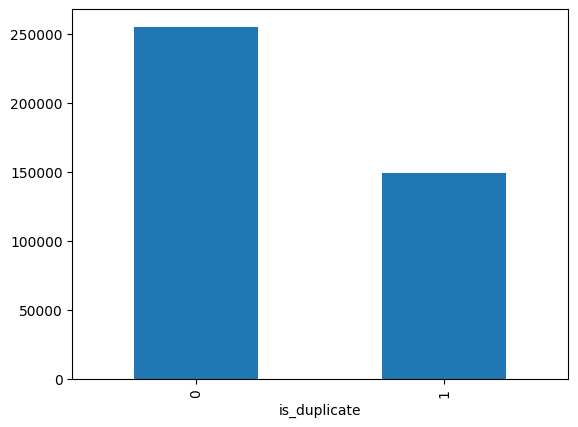

In [9]:
df['is_duplicate'].value_counts().plot(kind='bar')

**The dataset is imbalanced**  
But as the adatset is large , we can handle this by splitting dataset in a stratified fashion

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404351 non-null  int64 
 1   qid2          404351 non-null  int64 
 2   question1     404350 non-null  object
 3   question2     404349 non-null  object
 4   is_duplicate  404351 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [11]:
df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [14]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.duplicated()
print('Number of questions getting repeated : ',x.sum())

Number of unique questions :  789795
Number of questions getting repeated :  18901


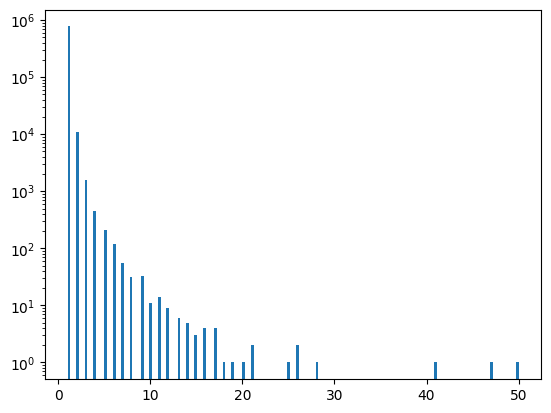

In [15]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [16]:
df.sample(20)

,qid1,qid2,question1,question2,is_duplicate
33598,66962,66963,What are the product based software companies ...,Where can I find a 3L (or more) container of G...,0
80926,160754,160755,Is Darth Vader’s castle located on the planet ...,How do you make a thing mysterious?,0
357293,699697,699698,How do I build a profile to get an MBA admissi...,What all should I do to build a strong profile...,1
57809,115014,115015,"If I eat something that will give me gas, how ...",Why does diet soda give me a headache?,0
88195,175128,175129,Why are 3-phase induction motors self-starting...,Why is torque not generated in a 3-phase trans...,0
308964,606537,606538,What is capital and revenue expenditure?,What's the difference between capital expendit...,1
237990,468813,468814,Who can help me in understanding that how psyc...,Can you explain one of the latest ideas in psy...,0
208979,412235,412236,How are people able to hide their mutual frien...,How do you find mutual friends on Facebook?,0
172460,340761,340762,Which is the best book for learning python for...,What is the best book for learning Python easily?,1
274642,540050,540051,How do I stop my mother-in-law from visiting a...,My mother-in-law takes over the kitchen when s...,0


### Steps for going ahead with the data :

1. Preprocessing
    * Remove Punctuation
    * Remove stopwords
    * Remoe 


In [17]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [18]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [19]:
df.head(20)

,qid1,qid2,question1,question2,is_duplicate
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0
5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1
6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0
7,15,16,how can i be a good geologist,what should i do to be a great geologist,1
8,17,18,when do you use シ instead of し,when do you use instead of and,0
9,19,20,motorola company can i hack my charter moto...,how do i hack motorola dcx3400 for free internet,0


In [20]:
df['q1_len'] = df['question1'].apply(lambda x : len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x : len(x.split()))

In [21]:
df['q1_num_words'] = df['question1'].apply(lambda x : len(x.split(' ')))
df['q2_num_words'] = df['question2'].apply(lambda x : len(x.split(' ')))

In [30]:
def common_words(row):
    
    w1 = set(row['question1'].split(' '))
    w2 = set(row['question2'].split(' '))
    
    return len(w1 & w2)
    

In [31]:
df['common_words'] = df.apply(common_words, axis=1)

In [36]:
df.head(10)

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,14,12,14,12,11,"[what, is, the, step, by, step, guide, to, inv..."
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,10,15,12,17,8,"[what, is, the, story, of, kohinoor, , koh, i,..."
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,14,10,14,10,4,"[how, can, i, increase, the, speed, of, my, in..."
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,11,12,12,16,1,"[why, am, i, mentally, very, lonely, , how, ca..."
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,13,7,15,7,4,"[which, one, dissolve, in, water, quikly, suga..."
5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,17,17,20,20,13,"[astrology, , i, am, a, capricorn, sun, cap, m..."
6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0,4,11,4,11,0,"[should, i, buy, tiago, what, keeps, childern,..."
7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,7,9,7,9,4,"[how, can, i, be, a, good, geologist, what, sh..."
8,17,18,when do you use シ instead of し,when do you use instead of and,0,8,7,8,12,6,"[when, do, you, use, シ, instead, of, し, when, ..."
9,19,20,motorola company can i hack my charter moto...,how do i hack motorola dcx3400 for free internet,0,9,9,12,9,4,"[motorola, , company, , , can, i, hack, my, ch..."


In [37]:
def total_words(row):
    
    w1 = len(row['question1'].split(' '))
    w2 = len(row['question2'].split(' '))
    
    return w1 + w2

In [38]:
df['total_words'] = df.apply(total_words, axis=1)

In [39]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [ ]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0] * 8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
        return token_features
    
    # Non stopwords
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Stopwords
    
    q1_stopwords = set([word for word in q1_tokens if word  in STOP_WORDS])
    q2_stopwords = set([word for word in q2_tokens if word  in STOP_WORDS])
    
    
    # Common Word Count
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Common Stopword Count
    
    common_stopword_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common Tokens from Question pair
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    #
        
    
    
    